In [ ]:
from dask_quantumtinkerer import Cluster, cluster_options
import dask.bag as db
import kwant
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse.linalg as sla
from ccode.modified_boundstate import modified_find_boundstates
from ccode.boundstate import find_boundstates, extract_boundstates
import time
import itertools as it

%matplotlib inline
plt.rcParams.update({"font.size": 12})

/opt/conda/lib/python3.9/site-packages/dask_gateway/client.py:21: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import LoopRunner, format_bytes


## Parallel computing configuration

In [ ]:
options = cluster_options()
options.worker_cores = 1  # you should always leave this to 1 (I think)
options.worker_memory = 4  # Need to atdjust this to meet your needs
options.extra_path = "/home/jtorresluna/work/trijunction_design/"  # Make sure to do this if you import any local modules!

In [ ]:
cluster = Cluster(options)

In [ ]:
cluster

In [ ]:
print(
    "http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/"
    + cluster.dashboard_link[17:]
)

http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/450bd6b7ad404db29780c97d9eac609a/status


In [ ]:
client = cluster.get_client()

In [ ]:
cluster.close()

# Analysis of bound state algorithm

#### Helper functions

In [ ]:
def sort_eigen(ev):
    """
    Sort eigenvectors and eigenvalues using numpy methods.
    """
    evals, evecs = ev
    idx = np.argsort(evals)
    evals = evals[idx]
    evecs = evecs[:, idx]
    return evals, evecs.T


def extract_data_bound_states(data, mus):
    energies = [[] for j in range(10)]
    states = [[] for j in range(10)]
    non_zero_mus = [[] for j in range(10)]
    i = 0
    for dat in data:
        ens = dat[0]
        vecs = dat[1]
        if 0 not in ens.shape:
            ens = np.sort(ens[np.where(ens>0)])
            j = 0
            for e in ens:
                energies[j].append(e)
                non_zero_mus[j].append(mus[i])
                states[j].append(vecs[j])
                j += 1
        i += 1
    return energies, non_zero_mus, states

In [ ]:
def add_phase(**params):
    params_copy = params.copy()
    Delta = params_copy['Delta']
    phi = params_copy.pop('phi')
    params_copy.update(Delta_im = np.sin(phi)*Delta)
    params_copy.update(Delta_re = np.cos(phi)*Delta)
    return params_copy

def bound_state_solver(key):

    def bound_state_iteration(system, mu, params):

        params[key] = mu
        en, vec = find_boundstates(syst=system,
                                   min_energy=-0.02,
                                   max_energy=0.02,
                                   sparse=True,
                                   params=add_phase(**params),
                                   rtol=1e-3
                                  )
        return en, vec

    return bound_state_iteration


solver_cavity_mu = bound_state_solver(key='mu_cavity')


def modified_bound_state_solver(key):

    def bound_state_iteration(system, mu, params):

        params[key] = mu
        en, vec = modified_find_boundstates(syst=system,
                                   min_energy=-0.02,
                                   max_energy=0.02,
                                   sparse=True,
                                   params=add_phase(**params),
                                   rtol=1e-3
                                  )
        return en, vec

    return bound_state_iteration


solver_cavity_mu = bound_state_solver(key='mu_cavity')

def wrapper_cavity_mu(args):
    return solver_cavity_mu(*args)

In [ ]:
# Hamiltonian of the system
lead_hamiltonian = """
    ( t * (k_x**2 + k_y**2 ) - mu) * kron(sigma_0, sigma_z)
    + alpha * k_x * kron(sigma_y, sigma_z)
    - alpha * k_y * kron(sigma_x, sigma_z)
    + Delta * kron(sigma_0, sigma_x)
    + B_x * kron(sigma_x, sigma_0)
"""

lead_phase_hamiltonian = """
    ( t * (k_x**2 + k_y**2 ) - mu) * kron(sigma_0, sigma_z)
    + alpha * k_x * kron(sigma_y, sigma_z)
    - alpha * k_y * kron(sigma_x, sigma_z)
    + Delta_re * kron(sigma_0, sigma_x)
    + Delta_im * kron(sigma_0, sigma_y)
    + B_x * kron(sigma_x, sigma_0)
"""
a = 1
lead1_template = kwant.continuum.discretize(lead_hamiltonian, grid=a)
lead2_template = kwant.continuum.discretize(lead_phase_hamiltonian, grid=a)

/tmp/ipykernel_2395/872729120.py:19: KwantDeprecationWarning: Accessing kwant.continuum without an explicit import is deprecated. Instead, explicitly 'import kwant.continuum'.
  lead1_template = kwant.continuum.discretize(lead_hamiltonian, grid=a)
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sy

In [ ]:
def interval_shape(L, W):
    def shape(site):
        return 0 <= site.pos[0] < L and 0 <= site.pos[1] < W
    return shape


def make_junction(L, W):
    junction = kwant.Builder()
    junction.fill(
        lead1_template,
        shape=interval_shape(L, W),
        start=[0,0]
    )
    return junction

In [ ]:
def circle_junction_shape(r, l, w):
    def shape(site):
        x, y = site.pos
        return x**2 + y**2 < r**2 or np.abs(x) < l + r and np.abs(y) < w
    return shape


def make_circular_junction(r, l, w):
    junction = kwant.Builder()
    junction.fill(
        template,
        shape=circle_junction_shape(r, l, w),
        start=[0,0]
    )
    return junction


def shape_wires_circle(r, mu_circle, mu_wires):
    def shape(x, y):
        if x**2 + y**2 < r**2:
            return mu_circle
        else:
            return mu_wires
    return shape


def f_params_circular_junction(r, **parameters):

    params = parameters.copy()
    mu_circle = params.pop('mu_cavity')
    mu_wires = params.pop('mu_wires')
    Delta = params.pop('Delta')

    params.update(mu=shape_wires_circle(r=r,
                                        mu_circle=mu_circle,
                                        mu_wires=mu_wires))
    params.update(Delta=shape_wires_circle(r=r,
                                           mu_circle=0,
                                           mu_wires=Delta))

    return params

# Single nanowire

### Infinite system

In [ ]:
L = 1
W = 3
rectangle = make_junction(L, W)

In [ ]:
lead = kwant.Builder(symmetry=kwant.TranslationalSymmetry([-1, 0]))
lead.fill(lead1_template, shape=lambda site: 0 <= site.pos[1] < W, start=[0, 0]);
rectangle.attach_lead(lead)
rectangle = rectangle.finalized()

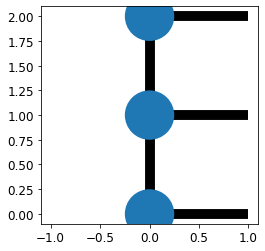

In [ ]:
kwant.plot(lead);

In [ ]:
params = {
    't': 1,
    'mu': 0.3,
    'alpha': 0.3,
    'Delta': 0.3,
    'B_x': 0.5
}

In [ ]:
%%time
start = time.time()
en, vec = find_boundstates(syst=rectangle,
                           min_energy=-0.01,
                           max_energy=0.01,
                           sparse=True,
                           params=params,
                           rtol=1e-3
                          )
end = time.time()
print(end-start)

find candidates:
0.7493796348571777
find all bound states:
0.02313375473022461
0.772925853729248
CPU times: user 771 ms, sys: 5.66 ms, total: 776 ms
Wall time: 773 ms


In [ ]:
%%time
start = time.time()
en, vec = modified_find_boundstates(syst=rectangle,
                           min_energy=-0.01,
                           max_energy=0.01,
                           sparse=True,
                           params=params,
                           rtol=1e-3
                          )
end = time.time()
print(end-start)

find candidates:
0.8192322254180908
[4.936372491326502e-16]
(24, 1)
find single bound state:
0.0357973575592041
0.8568172454833984
CPU times: user 853 ms, sys: 11.9 ms, total: 865 ms
Wall time: 857 ms


In [ ]:
en

array([4.93637249e-16])

In [ ]:
%%time
inf_ens = []
inf_vecs = []
Bs = np.linspace(0, 1, 20)
for b in Bs:
    params['B_x'] = b
    en, vec = find_boundstates(syst=rectangle,
                               min_energy=-0.01,
                               max_energy=0.01,
                               sparse=True,
                               params=params,
                               rtol=1e-3
                              )
    inf_ens.append(en)
    inf_vecs.append(vec)

find candidates:
1.024994134902954
find all bound states:
0.019872188568115234
find candidates:
1.138213872909546
find all bound states:
0.02057051658630371
find candidates:
1.111828088760376
find all bound states:
0.021616697311401367
find candidates:
1.0652878284454346
find all bound states:
0.02074122428894043
find candidates:
1.034635066986084
find all bound states:
0.020928144454956055
find candidates:
1.0395622253417969
find all bound states:
0.021315813064575195
find candidates:
0.995593786239624
find all bound states:
0.02057194709777832
find candidates:
0.984468936920166
find all bound states:
0.019385337829589844
find candidates:
0.6085939407348633
find all bound states:
0.01939225196838379
find candidates:
0.6207647323608398
find all bound states:
0.01901102066040039
find candidates:
0.5905094146728516
find all bound states:
0.020416259765625
find candidates:
0.5993986129760742
find all bound states:
0.01985478401184082
find candidates:
0.6201491355895996
find all bound stat

In [ ]:
%%time
inf_ens = []
inf_vecs = []
Bs = np.linspace(0, 1, 20)
for b in Bs:
    params['B_x'] = b
    en, vec = modified_find_boundstates(syst=rectangle,
                               min_energy=-0.01,
                               max_energy=0.01,
                               sparse=True,
                               params=params,
                               rtol=1e-3
                              )
    inf_ens.append(en)
    inf_vecs.append(vec)

find candidates:
1.1225850582122803
find single bound state:
0.019019603729248047
find candidates:
1.1009838581085205
find single bound state:
0.02035689353942871
find candidates:
1.1163110733032227
find single bound state:
0.020450592041015625
find candidates:
1.1266343593597412
find single bound state:
0.021359920501708984
find candidates:
1.2378087043762207
find single bound state:
0.02341747283935547
find candidates:
1.1792187690734863
find single bound state:
0.021679162979125977
find candidates:
1.1051535606384277
find single bound state:
0.021784067153930664
find candidates:
1.0998156070709229
find single bound state:
0.021320819854736328
find candidates:
0.6774439811706543
find single bound state:
0.02116680145263672
find candidates:
0.650484561920166
find single bound state:
0.020355224609375
find candidates:
0.6207802295684814
find single bound state:
0.019577741622924805
find candidates:
0.6129567623138428
find single bound state:
0.0193173885345459
find candidates:
0.623754

In [ ]:
w = np.where(np.abs(inf_ens)>0)[0][0]

/tmp/ipykernel_524/149243906.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  w = np.where(np.abs(inf_ens)>0)[0][0]
/tmp/ipykernel_524/149243906.py:1: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  w = np.where(np.abs(inf_ens)>0)[0][0]


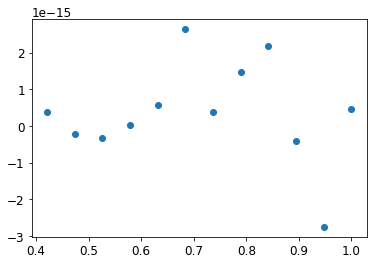

In [ ]:
plt.scatter(Bs[w:], inf_ens[w:])

In [ ]:
density = kwant.operator.Density(rectangle, np.eye(4))

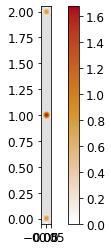

/tmp/ipykernel_849/3048305456.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  kwant.plotter.density(rectangle, density(inf_vecs[w][:, 0]));


In [ ]:
kwant.plotter.density(rectangle, density(inf_vecs[w][:, 0]));

In [ ]:
%%time
inf_vecs_0 = []
for b in Bs:
    params['B_x'] = b
    vec = extract_boundstates(syst=rectangle,
                             energy=0,
                             sparse=True,
                             params=params
                             )
    inf_vecs_0.append(vec)

CPU times: user 2.17 s, sys: 85.9 ms, total: 2.25 s
Wall time: 2.24 s


#### Notes on bound state algorithm:
* `fing_boundstates` takes longer when there's no bound state in the system.
* `extract_boundstate` is the fastest, but requires providing the energy.

### Finite system

In [ ]:
params = {
    't': 1,
    'mu': 0.3,
    'alpha': 0.3,
    'Delta': 0.3,
    'B_x': 0.011
}

In [ ]:
finite_wire = make_junction(100, 3).finalized()

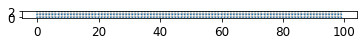

In [ ]:
kwant.plot(finite_wire);

In [ ]:
%%time
fin_ens = []
fin_vecs = []
for b in Bs:
    params['B_x'] = b
    ham = finite_wire.hamiltonian_submatrix(sparse=True, params=params)
    val, vec = sort_eigen(sla.eigsh(ham.tocsc(), k=10, sigma=0))
    fin_ens.append(val)
    fin_vecs.append(vec)

CPU times: user 2.68 s, sys: 15 ms, total: 2.7 s
Wall time: 2.69 s


In [ ]:
fin_ens = np.array(fin_ens)

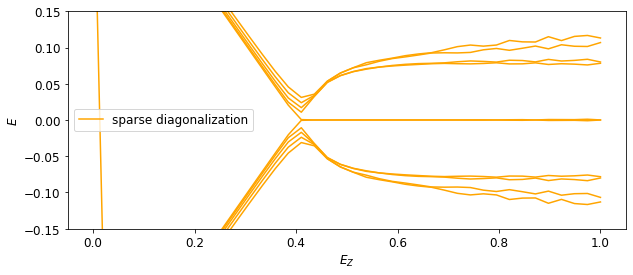

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4))
for level in fin_ens.T:
    ax.plot(Bs, level, label='sparse diagonalization', c='orange')
#ax.scatter(Bs[w:], inf_ens[w:], label='bound state algorithm')
ax.set_ylim(-0.15, 0.15)
ax.set_ylabel('$E$')
ax.set_xlabel(r'$E_Z$')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='center left')

In [ ]:
density = kwant.operator.Density(finite_wire, np.eye(4))

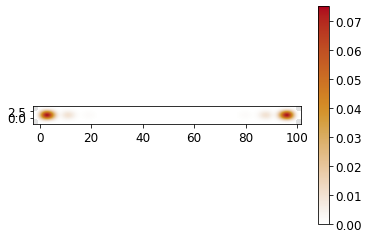

/tmp/ipykernel_849/3342805614.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  kwant.plotter.density(finite_wire, density(fin_vecs[50][5]));


In [ ]:
kwant.plotter.density(finite_wire, density(fin_vecs[50][5]));

# Circular cavity with two leads

In [ ]:
cavity_hamiltonian = """
    ( t * (k_x**2 + k_y**2 ) - mu_cavity) * kron(sigma_0, sigma_z)
    + alpha * k_x * kron(sigma_y, sigma_z)
    - alpha * k_y * kron(sigma_x, sigma_z)
    + B_x * kron(sigma_x, sigma_0)
"""

cavity_template = kwant.continuum.discretize(cavity_hamiltonian)

/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(


In [ ]:
def circle_shape(r):
    def shape(site):
        x, y = site.pos
        return x**2 + y**2 < r**2
    return shape


def make_circular_cavity(r):
    junction = kwant.Builder()
    junction.fill(
        cavity_template,
        shape=circle_shape(r),
        start=[0,0]
    )
    return junction

In [ ]:
circle = make_circular_cavity(r=14)
lead_1 = kwant.Builder(symmetry=kwant.TranslationalSymmetry([-1, 0]))
lead_2 = kwant.Builder(symmetry=kwant.TranslationalSymmetry([1, 0]))
W = 3
x0 = -9
y0 = 0
lead_1.fill(lead1_template,
          shape=lambda site: -W/2 + y0 <= site.pos[1] < W/2 + y0,
          start=[x0, y0]);
circle.attach_lead(lead_1)
lead_2.fill(lead2_template,
          shape=lambda site: -W/2 + y0 <= site.pos[1] < W/2 + y0,
          start=[x0, y0]);
circle.attach_lead(lead_2)
circle = circle.finalized()

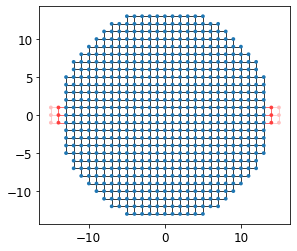

In [ ]:
kwant.plot(circle);

### Cavity eigenstates

In [ ]:
params = {
    't': 1,
    'mu': 0,
    'mu_cavity': 0,
    'alpha': 0.3,
    'Delta': 0.3,
    'B_x': 0.5
}

In [ ]:
%%time
cavity_ens = []
cavity_vecs = []
mus = np.linspace(-0.6, 1, 300)
for b in mus:
    params['mu_cavity'] = b
    ham = circle.hamiltonian_submatrix(sparse=True, params=params)
    val, vec = sort_eigen(sla.eigsh(ham.tocsc(), k=2, sigma=0))
    cavity_ens.append(val)
    cavity_vecs.append(vec)

CPU times: user 18.1 s, sys: 514 ms, total: 18.6 s
Wall time: 18.6 s


In [ ]:
cavity_ens = np.array(cavity_ens)

In [ ]:
gs = cavity_ens.T[0]

In [ ]:
peaks = np.where(np.abs(gs) < 2e-3)

Text(0.5, 0, '$\\mu_c$')

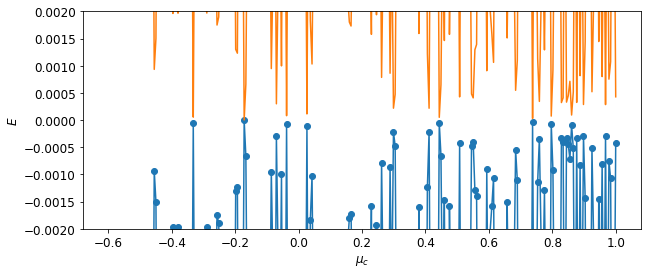

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4))
for level in cavity_ens.T:
    ax.plot(mus, level)
#ax.scatter(Bs[w:], inf_ens[w:], label='bound state algorithm')
ax.scatter(mus[peaks], gs[peaks])
ax.set_ylim(-0.002, 0.002)
ax.set_ylabel('$E$')
ax.set_xlabel(r'$\mu_c$')

### Majorana states

In [ ]:
solver_B = bound_state_solver(key='B_x')

In [ ]:
def wrapper_B(args):
    return solver_B(*args)

In [ ]:
params = {
    't': 1,
    'mu': 0.3,
    'mu_cavity': 0.4,
    'alpha': 0.3,
    'Delta': 0.3,
    'B_x': 0.5,
    'phi': 0
}

In [ ]:
%%time
en, vec = find_boundstates(syst=circle,
                           min_energy=-0.1,
                           max_energy=0.1,
                           sparse=True,
                           params=add_phase(**params),
                           rtol=0.05
                          )

find candidates:
10.4573233127594
[-0.06736028999839137, 0.026589723915564956, 0.06736028999841583]
(2456, 0)
(2460, 1)
(2456, 0)
find all bound states:
0.4147493839263916
CPU times: user 10.8 s, sys: 109 ms, total: 10.9 s
Wall time: 10.9 s


In [ ]:
en

array([0.02658972])

In [ ]:
np.shape(vec)

(2436, 1)

In [ ]:
%%time
en, vec = modified_find_boundstates(syst=circle,
                           min_energy=-0.1,
                           max_energy=0.1,
                           sparse=True,
                           params=add_phase(**params),
                           rtol= 0.001
                          )

energy intervals
-0.0005025125628140698 0.0005025125628140698
Time evaluate interval: 0.71785569190979
energy intervals
0.0005025125628140698 0.0015075376884422093
Time evaluate interval: 0.21031856536865234
energy intervals
-0.0015075376884422093 -0.0005025125628140698
Time evaluate interval: 0.20834684371948242
energy intervals
0.0015075376884422093 0.0025125628140703626
Time evaluate interval: 0.18702125549316406
energy intervals
-0.0025125628140703488 -0.0015075376884422093
Time evaluate interval: 0.18886303901672363
energy intervals
0.0025125628140703626 0.003517587939698502
Time evaluate interval: 0.16843867301940918
energy intervals
-0.0035175879396984883 -0.0025125628140703488
Time evaluate interval: 0.17195487022399902
energy intervals
0.003517587939698502 0.004522613065326642
Time evaluate interval: 0.1706535816192627
energy intervals
-0.004522613065326628 -0.0035175879396984883
Time evaluate interval: 0.16577792167663574
energy intervals
0.004522613065326642 0.00552763819095

In [ ]:
en

array([0.00657352])

In [ ]:
np.shape(vec)

(2436, 1)

In [ ]:
Bs = np.linspace(0, 1, 40)
args = list(it.product([circle], Bs, [params]))

In [ ]:
%%time
args_db = db.from_sequence(args, npartitions=20)
result = args_db.map(wrapper_B).compute()

CPU times: user 4.17 s, sys: 46.1 ms, total: 4.22 s
Wall time: 2min 9s


In [ ]:
energies, non_zero_Bs, states = extract_data_bound_states(data=result, mus=Bs)

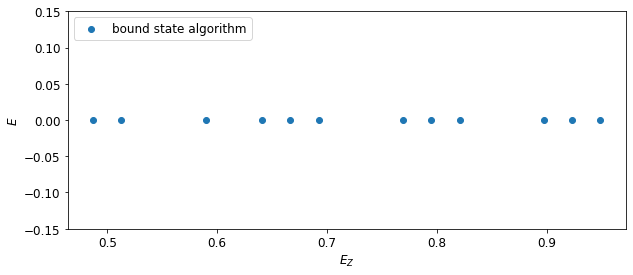

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4))
#for level in fin_ens.T:
 #   ax.plot(Bs, level, label='sparse diagonalization', c='orange')
ax.scatter(non_zero_Bs[0], energies[0], label='bound state algorithm')
ax.set_ylim(-0.15, 0.15)
ax.set_ylabel('$E$')
ax.set_xlabel(r'$E_Z$')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='upper left')

In [ ]:
%%time
start = time.time()
en, vec = find_boundstates(syst=circle,
                           min_energy=-0.02,
                           max_energy=0.02,
                           sparse=True,
                           params=add_phase(**params),
                           rtol=1e-3
                          )
end = time.time()
print(end-start)

find candidates:
17.19994854927063
find all bound states:
0.21126985549926758
17.41223645210266
CPU times: user 17.2 s, sys: 233 ms, total: 17.4 s
Wall time: 17.4 s


In [ ]:
vec

array([], shape=(2436, 0), dtype=float64)

In [ ]:
%%time
start = time.time()
en, vec = modified_find_boundstates(syst=circle,
                           min_energy=-0.01,
                           max_energy=0.01,
                           sparse=True,
                           params=add_phase(**params),
                           rtol=1e-3
                          )
end = time.time()
print(end-start)

find candidates:
10.790743350982666
[-1.9607819416693412e-12]
(2460, 0)
find single bound state:
0.2193131446838379
11.011169910430908
CPU times: user 10.9 s, sys: 129 ms, total: 11 s
Wall time: 11 s


In [ ]:
%%time
inf_ens = []
inf_vecs = []
Bs = np.linspace(0, 1, 20)
for b in Bs:
    params['B_x'] = b
    en, vec = find_boundstates(syst=circle,
                               min_energy=-0.01,
                               max_energy=0.01,
                               sparse=True,
                               params=add_phase(**params),
                               rtol=1e-3
                              )
    inf_ens.append(en)
    inf_vecs.append(vec)

find candidates:
11.603806972503662
find all bound states:
0.1870558261871338
find candidates:
11.154029846191406
find all bound states:
0.18995451927185059


KeyboardInterrupt: 

### Superconducting phase dependence

In [ ]:
solver_phi = bound_state_solver(key='phi')

In [ ]:
def wrapper_phi(args):
    return solver_phi(*args)

In [ ]:
params = {
    't': 1,
    'mu': 0.3,
    'mu_cavity': 0,
    'alpha': 0.3,
    'Delta': 0.3,
    'B_x': 0.5,
    'phi': 0
}

In [ ]:
phis = np.linspace(0, 2*np.pi, 50)
args = list(it.product([circle], phis, [params]))

In [ ]:
params_replaced = []
for phi in phis:
    params.update(phi=phi)
    params_replaced.append(add_phase(**params))

In [ ]:
%%time
args_db = db.from_sequence(args, npartitions=20)
result = args_db.map(wrapper_phi).compute()

CPU times: user 5.01 s, sys: 72.1 ms, total: 5.08 s
Wall time: 1min 55s


In [ ]:
energies_phi, non_zero_phi, states = extract_data_bound_states(data=result, mus=phis)

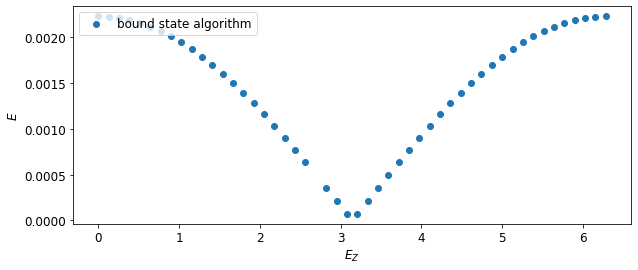

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4))
#for level in fin_ens.T:
 #   ax.plot(Bs, level, label='sparse diagonalization', c='orange')
ax.scatter(non_zero_phi[0], energies_phi[0], label='bound state algorithm')

ax.set_ylabel('$E$')
ax.set_xlabel(r'$E_Z$')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='upper left')


#### Finite system

In [ ]:
# Hamiltonian of the system
hamiltonian = """
    ( t * (k_x**2 + k_y**2 ) - mu(x,y)) * kron(sigma_0, sigma_z)
    + alpha * k_x * kron(sigma_y, sigma_z)
    - alpha * k_y * kron(sigma_x, sigma_z)
    + Delta_re(x,y) * kron(sigma_0, sigma_x)
    + Delta_im(x,y) * kron(sigma_0, sigma_y)
    + B_x * kron(sigma_x, sigma_0)
"""
a = 1
template = kwant.continuum.discretize(hamiltonian)


def circle_junction_shape(r, l, w):
    def shape(site):
        x, y = site.pos
        return x**2 + y**2 < r**2 or np.abs(x) < l + r and np.abs(y) < w/2
    return shape


def make_circular_junction(r, l, w):
    junction = kwant.Builder()
    junction.fill(
        template,
        shape=circle_junction_shape(r, l, w),
        start=[0, 0]
    )
    return junction


def shape_wires_circle(r, mu_circle, mu_wires):
    def shape(x, y):
        if x**2 + y**2 < r**2:
            return mu_circle
        else:
            return mu_wires
    return shape


def superconducting_phase(r, Delta, phi):

    def real_phase(x, y):
        if x < -r:
            return Delta*np.cos(phi)
        elif x > r:
            return Delta
        else:
            return 0

    def imaginary_phase(x, y):
        if x < -r:
            return Delta*np.sin(phi)
        else:
            return 0

    return real_phase, imaginary_phase


def f_params_circular_junction(r, **parameters):
    #print(parameters)
    params = parameters.copy()
    mu_circle = params.pop('mu_cavity')
    mu_wires = params.pop('mu_wires')
    Delta = params['Delta']
    phi = params.pop('phi')
    Delta_re, Delta_im = superconducting_phase(r, Delta, phi)
    params.update(Delta_re=Delta_re)
    params.update(Delta_im=Delta_im)

    params.update(mu=shape_wires_circle(r=r,
                                        mu_circle=mu_circle,
                                        mu_wires=mu_wires))


    return params

/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(


In [ ]:
f_params_circular_junction(14, **params)

{'t': 1,
 'alpha': 0.3,
 'Delta': 0.3,
 'B_x': 0.5,
 'Delta_re': <function __main__.superconducting_phase.<locals>.real_phase(x, y)>,
 'Delta_im': <function __main__.superconducting_phase.<locals>.imaginary_phase(x, y)>,
 'mu': <function __main__.shape_wires_circle.<locals>.shape(x, y)>}

In [ ]:
j = make_circular_junction(r=14, l=200, w=3).finalized()

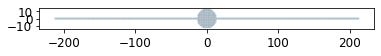

In [ ]:
kwant.plot(j);

In [ ]:
params = {
    't': 1,
    'mu_wires': 0.3,
    'mu_cavity': 0,
    'alpha': 0.3,
    'Delta': 0.3,
    'B_x': 0.5,
    'phi': 0
}

In [ ]:
phis = np.linspace(0, 2*np.pi, 100)

In [ ]:
%%time
cavity_ens = []
cavity_vecs = []
for b in phis:
    params['phi'] = b
    ham = j.hamiltonian_submatrix(sparse=True,
                                  params=f_params_circular_junction(r=14, **params))
    val, vec = sort_eigen(sla.eigsh(ham.tocsc(), k=8, sigma=0))
    cavity_ens.append(val)
    cavity_vecs.append(vec)

CPU times: user 26.2 s, sys: 361 ms, total: 26.5 s
Wall time: 26.5 s


In [ ]:
cavity_ens = np.array(cavity_ens)

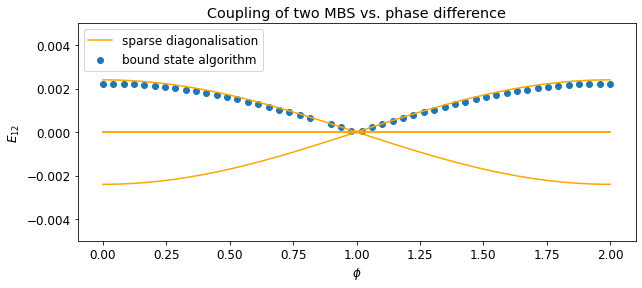

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4))
for level in cavity_ens.T:
    ax.plot(phis/np.pi, level, c='orange', label='sparse diagonalisation')
ax.scatter(np.array(non_zero_phi[0])/np.pi, energies_phi[0], label='bound state algorithm')
ax.set_ylim(-0.005, 0.005)
ax.set_title('Coupling of two MBS vs. phase difference')
ax.set_ylabel('$E_{12}$')
ax.set_xlabel(r'$\phi$')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='upper left')

In [ ]:
density = kwant.operator.Density(j, np.eye(4))

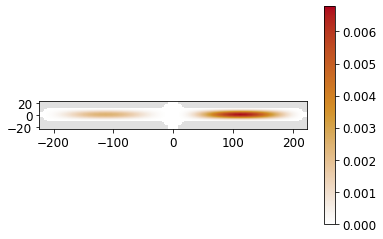

/tmp/ipykernel_156/1017518412.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  kwant.plotter.density(j, density(cavity_vecs[0][i]));


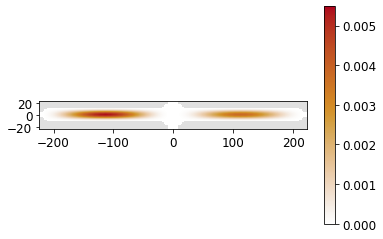

/tmp/ipykernel_156/1017518412.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  kwant.plotter.density(j, density(cavity_vecs[0][i]));


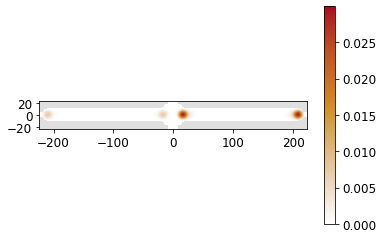

/tmp/ipykernel_156/1017518412.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  kwant.plotter.density(j, density(cavity_vecs[0][i]));


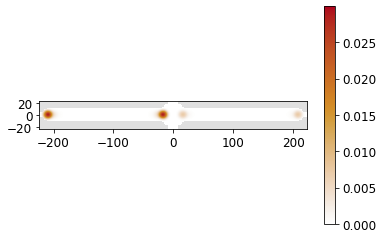

/tmp/ipykernel_156/1017518412.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  kwant.plotter.density(j, density(cavity_vecs[0][i]));


In [ ]:
for i in range(4):
    kwant.plotter.density(j, density(cavity_vecs[0][i]));

### Couple Majorana states

#### Infinite system

In [ ]:
solver_mu = bound_state_solver(key='mu_cavity')
modified_solver_mu = bound_state_solver(key='mu_cavity')

In [ ]:
def wrapper_mu(args):
    return solver_mu(*args)


def modified_wrapper_mu(args):
    return modified_solver_mu(*args)

In [ ]:
params = {
    't': 1,
    'mu': 0.3,
    'mu_cavity': -2,
    'alpha': 0.3,
    'Delta': 0.3,
    'B_x': 0.5,
    'phi': 0
}

In [ ]:
mus = np.linspace(-0.6, -0.05, 50)
args = list(it.product([circle], mus, [params]))

In [ ]:
%%time
args_db = db.from_sequence(args, npartitions=20)
result = args_db.map(wrapper_mu).compute()

CPU times: user 5.9 s, sys: 74.3 ms, total: 5.98 s
Wall time: 2min 24s


In [ ]:
energies, non_zero_mus, states = extract_data_bound_states(data=result, mus=mus)

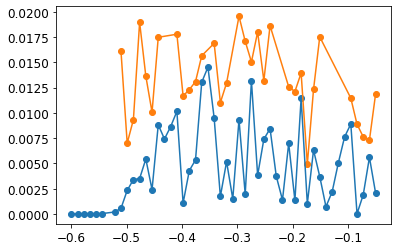

In [ ]:
for i in range(2):
    plt.scatter(non_zero_mus[i], energies[i], label=str(i)+'-th bound state energy')
    plt.plot(non_zero_mus[i], energies[i])

In [ ]:
%%time
args_db = db.from_sequence(args, npartitions=20)
modified_result = args_db.map(modified_wrapper_mu).compute()

CPU times: user 6.1 s, sys: 75.1 ms, total: 6.18 s
Wall time: 2min 14s


In [ ]:
energies, non_zero_mus, states = extract_data_bound_states(data=modified_result, mus=mus)

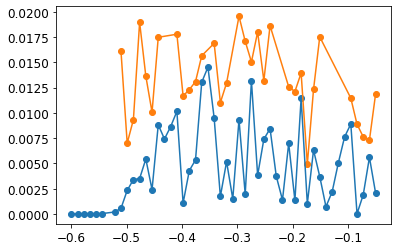

In [ ]:
for i in range(2):
    plt.scatter(non_zero_mus[i], energies[i], label=str(i)+'-th bound state energy')
    plt.plot(non_zero_mus[i], energies[i])

In [ ]:
mus = np.linspace(0, -0.05, 10)


In [ ]:
%%time
inf_ens = []
inf_vecs = []
for b in mus:
    params['mu_cavity'] = b
    en, vec = find_boundstates(syst=circle,
                               min_energy=-0.02,
                               max_energy=0.02,
                               sparse=True,
                               params=add_phase(**params),
                               rtol=1e-3
                              )
    inf_ens.append(en)
    inf_vecs.append(vec)

find candidates:
16.863770723342896
[-0.013776844962598971, -0.002232484832680126, -1.680513367352532e-17, 0.002232484832680114, 0.013776844962598971]
(2460, 0)
(2460, 1)
(2460, 0)
(2460, 1)
(2460, 0)
find all bound states:
0.877173900604248
find candidates:
16.990108489990234
[-0.016154132478682644, -0.002480871659787274, -2.8189256484623115e-17, 0.002480871659786967, 0.01615413247868263]
(2460, 0)
(2460, 1)
(2460, 0)
(2460, 1)
(2460, 0)
find all bound states:
0.8779451847076416
find candidates:
16.765753030776978
[-0.013664435894395498, -0.00257835425068063, -3.642919299551295e-17, 0.0025783542506806634, 0.013664435894395505]
(2460, 0)
(2460, 1)
(2460, 0)
(2460, 1)
(2460, 0)
find all bound states:
0.8696742057800293
find candidates:
16.581369876861572
[-0.010802732866714031, -0.0025517760955156266, -5.583641188300348e-17, 0.002551776095515765, 0.010802732866714028]
(2460, 0)
(2460, 1)
(2460, 0)
(2460, 1)
(2460, 0)
find all bound states:
0.7838232517242432
find candidates:
16.21623945

In [ ]:
%%time
mod_inf_ens = []
mod_inf_vecs = []
for b in mus:
    params['mu_cavity'] = b
    en, vec = modified_find_boundstates(syst=circle,
                               min_energy=-0.02,
                               max_energy=0.02,
                               sparse=True,
                               params=add_phase(**params),
                               rtol=1e-3
                              )
    mod_inf_ens.append(en)
    mod_inf_vecs.append(vec)

find candidates:
1.6303677558898926
[-1.5504091066542713e-17, 0.002232484832680112]
(2460, 0)
(2460, 1)
find single bound state:
0.30583620071411133
find candidates:
1.5078976154327393
[-2.8080836267374565e-17, 0.002480871659786967]
(2460, 0)
(2460, 1)
find single bound state:
0.36156344413757324
find candidates:
2.0480117797851562
[-3.426078865054194e-17, 0.0025783542506806634]
(2460, 0)
(2460, 1)
find single bound state:
0.32802438735961914
find candidates:
1.4668514728546143
[-5.637851296924623e-17, 0.002551776095515765]
(2460, 0)
(2460, 1)
find single bound state:
0.2949862480163574
find candidates:
1.5061254501342773
[-3.5887091909270197e-17, 0.0024302409615550276]
(2460, 0)
(2460, 1)
find single bound state:
0.2693212032318115
find candidates:
1.4814140796661377
[-3.67544536472586e-17, 0.0022425737967895166]
(2460, 0)
(2460, 1)
find single bound state:
0.27121686935424805
find candidates:
1.5193743705749512
[8.673617379884035e-18, 0.002016550705897658]
(2460, 0)
(2460, 1)
find si

In [ ]:
np.array(mod_inf_ens)

array([[0.00223248],
       [0.00248087],
       [0.00257835],
       [0.00255178],
       [0.00243024],
       [0.00224257],
       [0.00201655],
       [0.00184596],
       [0.0017605 ],
       [0.00203189]])

In [ ]:
extracted_ens = []
for element in inf_ens:
    l = len(element)
    extracted_ens.append(np.sort(element)[int(l/2)])

In [ ]:
extracted_ens = np.array(extracted_ens)

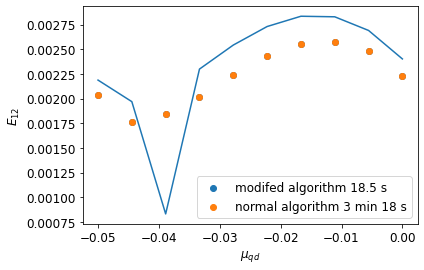

In [ ]:
level = cavity_ens.T[-2]

plt.scatter(mus, mod_inf_ens, label='modifed algorithm 18.5 s')
plt.scatter(mus, extracted_ens, label='normal algorithm 3 min 18 s')
plt.plot(mus, level)
plt.xlabel(r'$\mu_{qd}$')
plt.ylabel(r'$E_{12}$')
plt.legend()

In [ ]:
params = {
    't': 1,
    'mu_wires': 0.3,
    'mu_cavity': 0,
    'alpha': 0.3,
    'Delta': 0.3,
    'B_x': 0.5,
    'phi': 0
}
mus = np.linspace(0, -0.05, 10)

In [ ]:
%%time
cavity_ens = []
cavity_vecs = []
for b in mus:
    params['mu_cavity'] = b
    ham = j.hamiltonian_submatrix(sparse=True,
                                  params=f_params_circular_junction(r=14, **params))
    val, vec = sort_eigen(sla.eigsh(ham.tocsc(), k=6, sigma=0))
    cavity_ens.append(val)
    cavity_vecs.append(vec)

CPU times: user 1.91 s, sys: 53 ms, total: 1.96 s
Wall time: 1.96 s


In [ ]:
cavity_ens = np.array(cavity_ens)

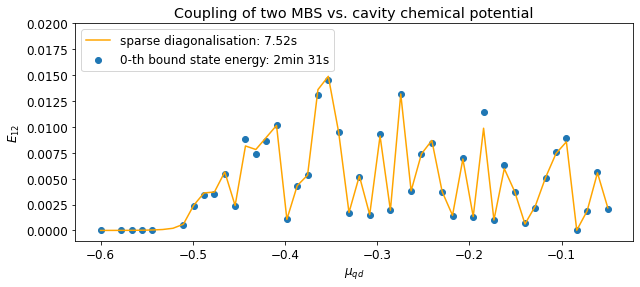

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4))
level = cavity_ens.T[-1]
ax.plot(mus, level, c='orange', label='sparse diagonalisation: 7.52s')
ax.scatter(non_zero_mus[0], energies[0], label=str(i)+'-th bound state energy: 2min 31s')
ax.set_title('Coupling of two MBS vs. cavity chemical potential')
ax.set_ylabel('$E_{12}$')
ax.set_xlabel(r'$\mu_{qd}$')
ax.set_ylim(-0.001, 0.02)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='upper left')

## Modify bound state script

In [ ]:
min_energy = -0.02
max_energy = -min_energy
rtol = 0.5e-2

In [ ]:
energies = np.linspace(
    min_energy, max_energy, int((max_energy - min_energy) / rtol)
)
intervals = list(zip(energies, energies[1:]))
sorted_intervals = sorted(iss, key=lambda element: np.abs(element[0]))
candidates = []

In [ ]:
iss = list(intervals)

In [ ]:
ee = sorted(iss, key=lambda element: np.abs(element[0]))

In [ ]:
for a, b in ee:
    print(a, b)

-0.0028571428571428567 0.0028571428571428567
0.0028571428571428567 0.00857142857142857
0.00857142857142857 0.014285714285714287
-0.008571428571428572 -0.0028571428571428567
-0.014285714285714287 -0.008571428571428572
0.014285714285714287 0.02
-0.02 -0.014285714285714287


In [ ]:
ee

[-0.0028571428571428567,
 0.0028571428571428567,
 0.00857142857142857,
 -0.008571428571428572,
 -0.014285714285714287,
 0.014285714285714287,
 -0.02,
 0.02]

In [ ]:
ee

[-0.0028571428571428567,
 0.0028571428571428567,
 0.00857142857142857,
 -0.008571428571428572,
 -0.014285714285714287,
 0.014285714285714287,
 -0.02,
 0.02]

In [ ]:
for a, b in intervals:
    print(a, b)

-0.02 -0.014285714285714287
-0.014285714285714287 -0.008571428571428572
-0.008571428571428572 -0.0028571428571428567
-0.0028571428571428567 0.0028571428571428567
0.0028571428571428567 0.00857142857142857
0.00857142857142857 0.014285714285714287
0.014285714285714287 0.02


In [ ]:
sorted(energies, key=abs)

[-0.0028571428571428567,
 0.0028571428571428567,
 0.00857142857142857,
 -0.008571428571428572,
 -0.014285714285714287,
 0.014285714285714287,
 -0.02,
 0.02]

In [ ]:
sorted(energies, key=abs)[::-1]

[0.02,
 -0.02,
 0.014285714285714287,
 -0.014285714285714287,
 -0.008571428571428572,
 0.00857142857142857,
 0.0028571428571428567,
 -0.0028571428571428567]